In [101]:
# explore data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime
print('main imports done')

main imports done


In [102]:
df = pd.read_csv('./data/Matches.csv', low_memory=False)
print(df.shape)

(228377, 42)


In [103]:
# just EPL
df = df[df['Division'] == "E0"]
print(df.shape, "we will look at 18 months data")
df = df[df['MatchDate'] > "2023-07-01"]

df.shape



(9300, 42) we will look at 18 months data


(650, 42)

In [104]:
# prune off lots of columns we wont use - see the ReadMe for the dataset
df = df.drop(columns=['Division', 'HTHome', 'HTAway','HomeTarget','AwayTarget','HomeCorners','AwayCorners', 'HomeYellow', 'AwayYellow','HomeFouls', 'AwayFouls', 'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw',\
    'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize', 'HandiHome', 'HandiAway'])
df.columns

Index(['MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo',
       'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTHome', 'FTAway',
       'FTResult', 'HTResult', 'HomeShots', 'AwayShots', 'HomeRed', 'AwayRed'],
      dtype='object')

In [105]:

# make matchTime just the hour to treat it as a factor
df['MatchTime'] = df['MatchTime'].str.slice(0,2)
df['MatchTime'] = pd.to_numeric(df['MatchTime'], errors='coerce')

# factorize the HTResult and FTresult too, check they are done in same way 
codes, uniques = df['FTResult'].factorize()
df['Target'] = codes - 1 # do this to have DRAW as zero
print(uniques)

# calculate a difference for Elo
df['EloDiff'] = df['HomeElo'] - df['AwayElo']

print(df.tail())
num_cols = ['MatchTime', 'Target', 'HomeRed', 'AwayRed','EloDiff','HomeShots', 'AwayShots', 'Form5Home','Form5Away' ]
print(df[num_cols].corr())   

df[['HomeTeam', 'AwayTeam','EloDiff','FTResult']].head(6)


Index(['A', 'H', 'D'], dtype='object')
         MatchDate  MatchTime       HomeTeam   AwayTeam  HomeElo  AwayElo  \
228372  2025-02-26         19      Brentford    Everton  1738.05  1731.52   
228373  2025-02-26         19     Man United    Ipswich  1757.62  1584.51   
228374  2025-02-26         19  Nott'm Forest    Arsenal  1788.28  1999.49   
228375  2025-02-26         19      Tottenham   Man City  1785.53  1926.48   
228376  2025-02-26         20      Liverpool  Newcastle  1995.58  1826.18   

        Form3Home  Form5Home  Form3Away  Form5Away  FTHome  FTAway FTResult  \
228372        6.0        9.0        5.0       11.0     1.0     1.0        D   
228373        1.0        4.0        1.0        1.0     3.0     2.0        H   
228374        3.0        6.0        6.0       10.0     0.0     0.0        D   
228375        9.0        9.0        3.0        9.0     0.0     1.0        A   
228376        7.0       11.0        3.0        6.0     2.0     0.0        H   

       HTResult  HomeSh

,HomeTeam,AwayTeam,EloDiff,FTResult
210362,Burnley,Man City,-350.85,A
210372,Arsenal,Nottm Forest,245.40,H
210375,Bournemouth,West Ham,-118.82,D
210376,Brighton,Luton,221.66,H
210377,Everton,Fulham,-28.40,A
210378,Sheffield United,Crystal Palace,-113.33,A


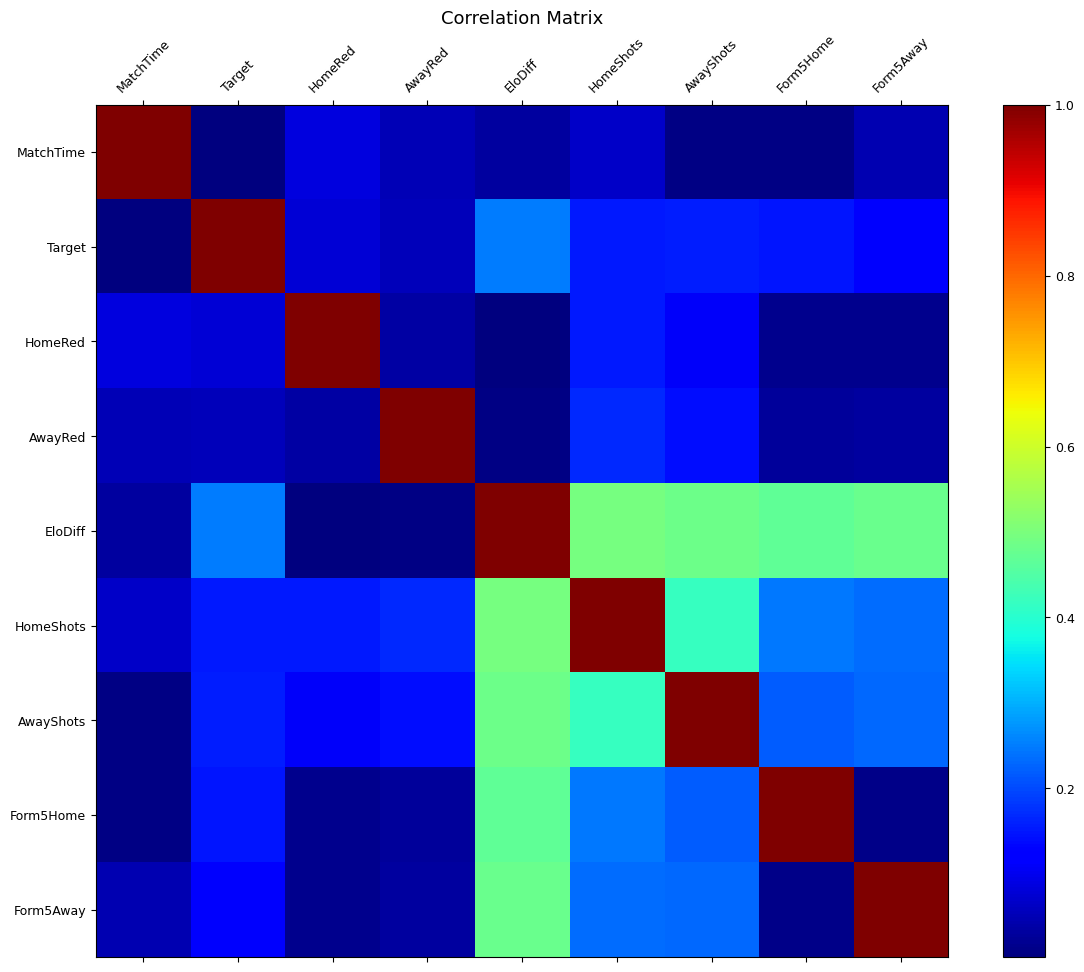

In [106]:
# visually inspect these correlations
f = plt.figure(figsize=(14, 11))

# abs() makes it a bit easier to see the correlations
plt.matshow(df[num_cols].corr().abs(), fignum=f.number, cmap='jet')
plt.xticks(range(df[num_cols].shape[1]), df[num_cols].columns, fontsize=9, rotation=45)
plt.yticks(range(df[num_cols].shape[1]), df[num_cols].columns, fontsize=9)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=9)
plt.title('Correlation Matrix', fontsize=13);


In [107]:
# plots
nan_rows = df.isna().any(axis=1)
print(df[nan_rows], df.shape)
df.dropna(inplace=True)

df.shape

         MatchDate  MatchTime       HomeTeam       AwayTeam  HomeElo  AwayElo  \
226793  2024-12-26         15  Nott'm Forest      Tottenham      NaN  1812.92   
226880  2024-12-29         15        Everton  Nott'm Forest  1711.92      NaN   

        Form3Home  Form5Home  Form3Away  Form5Away  FTHome  FTAway FTResult  \
226793        0.0        0.0        3.0        4.0     1.0     0.0        H   
226880        3.0        6.0        9.0       15.0     0.0     2.0        A   

       HTResult  HomeShots  AwayShots  HomeRed  AwayRed  Target  EloDiff  
226793        H       10.0       13.0      0.0      1.0       0      NaN  
226880        A       13.0       11.0      0.0      0.0      -1      NaN   (650, 20)


(648, 20)

In [108]:
# 3 x target values so try a multinomial logistic regression
# concepts outlined in this example>>
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
# good reference also is https://forecastegy.com/posts/train-logistic-regression-scikit-learn-python/
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# evaluate multinomial logistic regression model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std


In [109]:
# setup X data and y target labels
# before setting up the data, lets also reserve some of the later season's results to inspect our model on 
# (beyond the training and test sets we will do!)
# remove the NA rows

n = -39 # splits on February 2025 and sets the games after aside as a Holdout
df_numeric = df[num_cols].copy()

# remove the cols with stats from the game itself just to make things simpler
df_numeric.drop(['HomeShots', 'AwayShots','HomeRed','AwayRed'], axis=1, inplace=True)

print(df_numeric.iloc[0,:])
X = df_numeric.iloc[:n, :]
df_holdout = df_numeric.iloc[n:, :]

# the labelled outcomes are then:
y = X.Target

# ensure the y label column is removed from the dataset!
del X['Target']
X.iloc[0,:]

MatchTime     20.00
Target        -1.00
EloDiff     -350.85
Form5Home     10.00
Form5Away     10.00
Name: 210362, dtype: float64


MatchTime     20.00
EloDiff     -350.85
Form5Home     10.00
Form5Away     10.00
Name: 210362, dtype: float64

In [110]:
# preprocess data - scale / standardise as we are using Logistic Regression 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# need to split into test training before scaling to avoid leakage
# i.e. in production we would not know the mean and STD of the test!! :) 
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.3, random_state=42)

# fit scaler on the training data only:
scaler.fit(X_train)

# Transform both the training and testing data using our fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.iloc[0, :])

MatchTime    15.00
EloDiff     -47.64
Form5Home     1.00
Form5Away     3.00
Name: 213513, dtype: float64


In [111]:
# multinomial Log Reg requires a change to the loss function used to train the model (e.g. log loss to cross-entropy loss), 
# and a change to the output from a single probability value to one probability for each class label.
# TODO try with various penalties to improve the model e.g. experiment with  args penalty='l2', C=1.0

# https://scikit-learn.org/1.5/auto_examples/linear_model/plot_logistic_multinomial.html
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty='l2', C=1) # other solver is lbfgs / newton-cg / sag
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6338797814207651


C:\Users\batte\miniconda3\envs\pandas_ex\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [112]:
proba_test = model.predict_proba(X_test_scaled)
a = -2
b = -1

print(model.classes_) #  -1 is away win 0 is draw, 1 is home win

# print the probabilities in reverse so hom ewin comes first!
print(np.flip(proba_test[a:b]))
print(X_test.columns)
print(X_test_scaled[a:b])


[-1  0  1]
[[0.24444675 0.25583542 0.49971783]]
Index(['MatchTime', 'EloDiff', 'Form5Home', 'Form5Away'], dtype='object')
[[0.25       0.35238702 0.4        0.6       ]]


In [113]:

y_holdout = df_holdout.Target
df_holdout = df_holdout.drop(columns='Target', axis=1, errors='ignore')
df_holdout.head()
holdout_scaled = scaler.transform(df_holdout)


In [114]:
results = ('H', 'D', 'A')
for count, value in enumerate(y_holdout):
    print(df.loc[y_holdout.index[count],['MatchDate', 'HomeTeam', 'AwayTeam', 'EloDiff', 'HTResult', 'FTResult']].to_markdown())
    check_result = holdout_scaled[count]
    predicted = np.flip(model.predict_proba([check_result]))
    print('PREDICTION WAS:', predicted)
    print(results[np.argmax(predicted)].upper())


|           | 227682            |
|:----------|:------------------|
| MatchDate | 2025-02-01        |
| HomeTeam  | Everton           |
| AwayTeam  | Leicester         |
| EloDiff   | 96.82999999999993 |
| HTResult  | H                 |
| FTResult  | H                 |
PREDICTION WAS: [[0.27667613 0.46919459 0.25412928]]
D
|           | 227683             |
|:----------|:-------------------|
| MatchDate | 2025-02-01         |
| HomeTeam  | Ipswich            |
| AwayTeam  | Southampton        |
| EloDiff   | 48.930000000000064 |
| HTResult  | D                  |
| FTResult  | A                  |
PREDICTION WAS: [[0.2875758 0.414688  0.2977362]]
D
|           | 227684           |
|:----------|:-----------------|
| MatchDate | 2025-02-01       |
| HomeTeam  | Newcastle        |
| AwayTeam  | Fulham           |
| EloDiff   | 81.3900000000001 |
| HTResult  | H                |
| FTResult  | A                |
PREDICTION WAS: [[0.30458108 0.4680904  0.22732852]]
D
|           | 227723  